# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import random
# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [7]:
default_seed = 1
output_file = "output_sample"

In [6]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Prepare functions to fit and evaluate models

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

continuous_features = list(set(continuous_features) - set(["last_pymnt_amnt","last_fico_range_high", "last_fico_range_low"]))
discrete_features = list(set(discrete_features) - set(["title","zip_code","emp_length","emp_title"]))

## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
def status(x):
    return(x  in ["Charged Off", "Default"] )
data["outcome"] = list(map( status,data["loan_status"]))

# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
def training_test(p):
    a = np.random.binomial(1,p)
    if a == 1:
        return True
    return False
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p = 0.5
data['train'] = list(map(training_test, [p]*len(data['cr_hist'])))
data["outcome"] = list(map( status,data["loan_status"]))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## define your set of features to use in different models
your_features = continuous_features + discrete_features

# prepare the train, test data for training models
#data_dict = prepare_data(feature_subset = your_features)

#all_features = pd.Series(continuous_features + discrete_features_dummies)
#idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
#                                                     if j.split("::")[0] in your_features]
#selected_features = all_features[idx]
#selected_features.reset_index(drop=True,inplace=True)


In [8]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice(np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [7]:
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [8]:
def fit_classification(model, data_dict,variables_set,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True,
                          metric = "accuracy",
                          number_iterations  = 100
                          
                      ):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, scoring = metric)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    your_features = continuous_features + discrete_features
    # prepare the train, test data for training models
    auc_a = np.zeros(number_iterations)
    best_threshold_a = np.zeros(number_iterations)
    best_accuracy_a = np.zeros(number_iterations)
    best_recall_a = np.zeros(number_iterations)
    best_f1_a = np.zeros(number_iterations)
    best_precision_a = np.zeros(number_iterations)
    
    for i in range(number_iterations):
        data_dict = prepare_data(feature_subset = variables_set, random_state = random.randint(1,2000))
        X_train = data_dict['X_train']
        y_train = data_dict['y_train']
        X_test = data_dict['X_test']
        y_test = data_dict['y_test']
        filter_train = data_dict['train_set']  
        model = best_model.fit(X_train,y_train)

        try:
            y_pred_probs = model.predict_proba(X_test)[:,1]
            auc_a[i] = roc_auc_score(y_test, y_pred_probs)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
            probs_predicted = True
        except:
            probs_predicted = False
        # Make predictions; if we were able to find probabilities, use
        # the threshold that maximizes the accuracy in the training set.
        # If not, just use the learner's predict function
        if probs_predicted:
            y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

            true_pos_train = tpr_train*(y_train.sum())
            true_neg_train = (1 - fpr_train) *(1-y_train).sum()

            best_threshold_index = np.argmax(true_pos_train + true_neg_train)
            best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
            best_threshold_a[i]  = best_threshold
            precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
            best_recall_a[i] = recall[best_threshold_index]
            best_precision_a[i] = precision[best_threshold_index]
            best_f1_a[i] = 2*best_precision_a[i]*best_recall_a[i]/(best_precision_a[i] + best_recall_a[i])
            y_pred = (y_pred_probs > best_threshold)
            best_accuracy_a[i] = accuracy_score(y_test, y_pred)
            y_pred = (y_pred_probs > best_threshold)
        else:
            y_pred = best_model.predict(X_test)
        
    auc_avg = np.average(auc_a)
    auc_std = np.std(auc_a)
    precision_avg = np.average(best_precision_a)
    precision_std = np.std(best_precision_a)
    recall_avg = np.average(best_recall_a)
    recall_std = np.std(best_recall_a)
    f1_avg = np.average(best_f1_a)
    f1_std = np.std(best_f1_a)
    best_threshold_avg = np.average(best_threshold_a)
    best_threshold_std = np.std(best_threshold_a)
    best_accuracy_avg = np.average(best_accuracy_a)
    best_accuracy_std = np.std(best_accuracy_a)
    
    print("AUC-average and standard deviation: " + str(auc_avg) + "," + str(auc_std) )
    print("Accuracy-average and standard deviation: " + str(best_accuracy_avg) + "," + str(best_accuracy_std))
    print("Precision-average and standard deviation: " + str(precision_avg) + "," + str(precision_std))
    print("Recall-average and standard deviation: " + str(recall_avg) + "," + str(recall_std))
    print("F1-average and standard deviation: " + str(f1_avg) + "," + str(f1_std))
    print("Thresholds-average and standard deviation: " + str(best_threshold_avg) + "," + str(best_threshold_std))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

### Naive Bayes

  Model: NB
Fit time: 1.09 seconds
Optimal parameters:
{'var_smoothing': 3e-10}

AUC-average and standard deviation: 0.6763375846497831,0.004541872093484471
Accuracy-average and standard deviation: 0.7913089999999999,0.0031905671909552417
Precision-average and standard deviation: 0.20874486072783136,0.00319014917735113
Recall-average and standard deviation: 1.0,0.0
F1-average and standard deviation: 0.34537959156069326,0.004361956563569288
Thresholds-average and standard deviation: 1.0,0.0


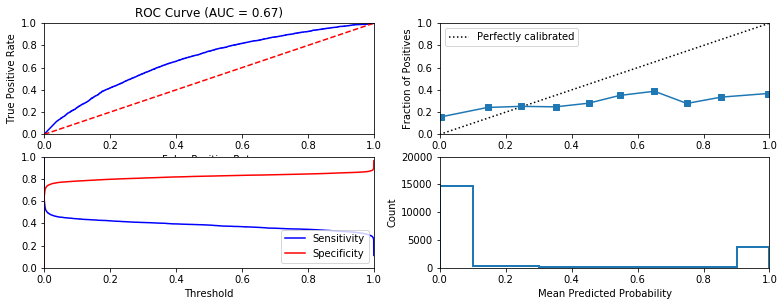


Similarity to LC grade ranking:  0.7370920709769441
Brier score: 0.25219363621888385
Were parameters on edge? : True
Score variations around CV search grid : 2.6551385822908937
[0.52916667 0.53826667 0.5436    ]


In [9]:
## Train and test a naive bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = fit_classification(gnb,data_dict, your_features, cv_parameters = {"var_smoothing":[0.0000000001, 0.0000000002,0.0000000003]}, model_name = "NB", number_iterations = 100)

### $l_1$ regularized logistic regression

  Model: L1 regularized logistic regression
Fit time: 61.2 seconds
Optimal parameters:
{'C': 2, 'penalty': 'l1'}

AUC-average and standard deviation: 0.7103138815784851,0.004412861122691344
Accuracy-average and standard deviation: 0.7935584999999999,0.0029362821305181164
Precision-average and standard deviation: 0.21441705462052915,0.003291743935392356
Recall-average and standard deviation: 0.9959996940349659,0.0016179422502508316
F1-average and standard deviation: 0.35285626058212943,0.004434305402910643
Thresholds-average and standard deviation: 0.49438226606443725,0.01933792409405855


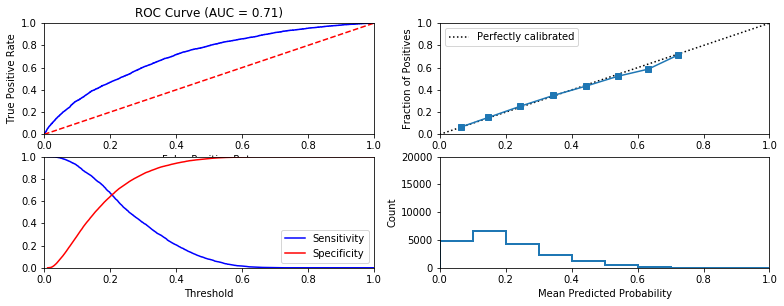


Similarity to LC grade ranking:  0.7102018362697918
Brier score: 0.14746422066852494
Were parameters on edge? : True
Score variations around CV search grid : 0.08368200836819162
[0.796      0.79646667 0.7965     0.79663333 0.7964     0.79666667
 0.7964    ]


In [10]:
## Train and test a l_1 regularized logistic regression classifier

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

l1_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
l1_logistic_class = fit_classification(l1_logistic, data_dict, your_features, cv_parameters, 'L1 regularized logistic regression', number_iterations = 100)



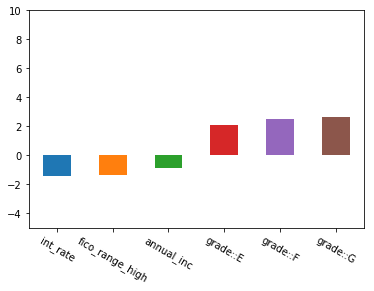

In [11]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic_class['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic_class['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic_class['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### $l_2$ regularized logistic regression

  Model: L2 regularized logistic regression
Fit time: 91.9 seconds
Optimal parameters:
{'C': 2, 'penalty': 'l2'}

AUC-average and standard deviation: 0.7099563517696619,0.004101024995624529
Accuracy-average and standard deviation: 0.7939215000000001,0.0032437960401356923
Precision-average and standard deviation: 0.2139726961934381,0.0034695783074732214
Recall-average and standard deviation: 0.9960843522782988,0.0015855833522990259
F1-average and standard deviation: 0.35225766523278734,0.004660703518485404
Thresholds-average and standard deviation: 0.4949452845756525,0.019713201684014338


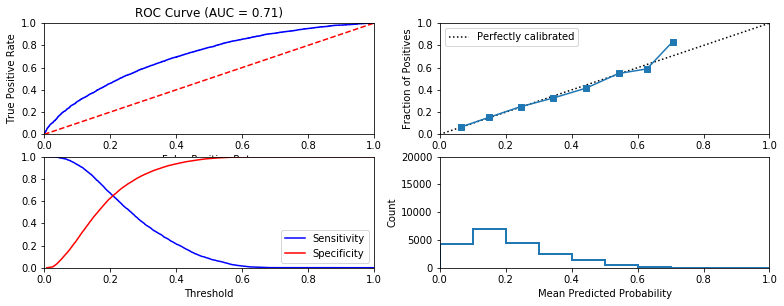


Similarity to LC grade ranking:  0.6960019475604345
Brier score: 0.14904510142915336
Were parameters on edge? : True
Score variations around CV search grid : 0.0711059059729022
[0.7967     0.7967     0.79646667 0.79636667 0.7968     0.79683333
 0.79693333 0.7967     0.79663333 0.79673333 0.79663333]


In [12]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l2'], 'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1,2,3, 3.5, 4, 5]}

l2_logistic = fit_classification(l2_logistic, data_dict, your_features, cv_parameters, 'L2 regularized logistic regression', number_iterations = 100)

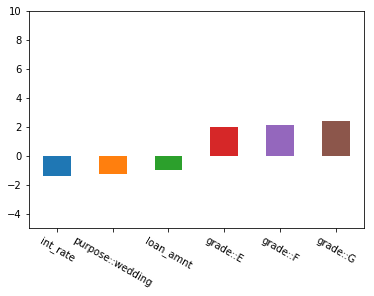

In [13]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: decision_tree
Fit time: 2.41 seconds
Optimal parameters:
{'max_depth': 4}

AUC-average and standard deviation: 0.6856506320513326,0.004104536442180725
Accuracy-average and standard deviation: 0.7915010000000001,0.003027713493711053
Precision-average and standard deviation: 0.23390251766211662,0.019854404539243392
Recall-average and standard deviation: 0.9442265288966608,0.06219668262781099
F1-average and standard deviation: 0.37349357152719037,0.01875457825362984
Thresholds-average and standard deviation: 0.5932843479640465,0.1343642883796479


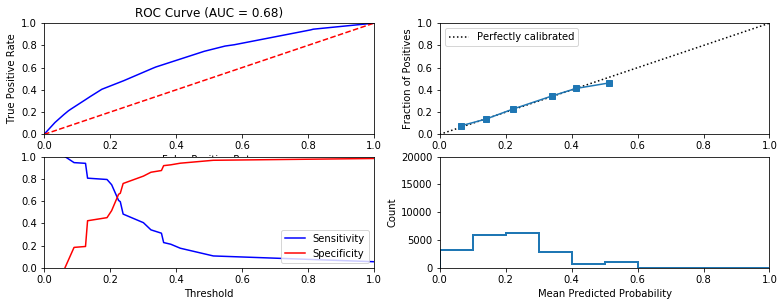


Similarity to LC grade ranking:  0.8178921834183843
Brier score: 0.15436120704282133
Were parameters on edge? : False
Score variations around CV search grid : 100.0
[0.         0.         0.01922643 0.06665993 0.03764677]


In [14]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()
cv_parameters = {"max_depth":range(1,6)}
decision_tree = fit_classification(decision_tree,data_dict , your_features, cv_parameters=cv_parameters,model_name="decision_tree", metric="recall",  number_iterations = 100)


### Random forest

  Model: RF
Fit time: 37.97 seconds
Optimal parameters:
{'max_depth': 15, 'n_estimators': 100}

AUC-average and standard deviation: 0.7041592891364256,0.004293172671524581
Accuracy-average and standard deviation: 0.7689595000000002,0.004460676490175006
Precision-average and standard deviation: 0.21949037630779988,0.003444803109767621
Recall-average and standard deviation: 0.9886612019945166,0.0025652774266371747
F1-average and standard deviation: 0.35921375572329173,0.004548138292288074
Thresholds-average and standard deviation: 0.32520628812999824,0.009424694817102126


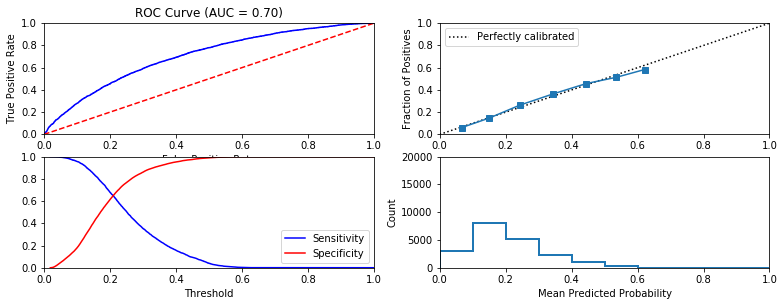


Similarity to LC grade ranking:  0.662090665160218
Brier score: 0.15300857114262845
Were parameters on edge? : True
Score variations around CV search grid : 0.05861173909403746
[0.7958     0.79573333 0.7958     0.7962     0.7958     0.7959    ]


In [15]:
## Train and test a random forest classifier

from sklearn.ensemble import RandomForestClassifier

cv_parameters = {
    "n_estimators": [50,100]
    , "max_depth": [11,15,17]
}
random_forest = RandomForestClassifier(random_state = default_seed, n_jobs = -1)
random_forest = fit_classification(random_forest,data_dict, your_features, cv_parameters = cv_parameters, model_name = "RF", number_iterations = 100)

  Model: RF
Fit time: 29.17 seconds
Optimal parameters:
{'max_depth': 23, 'n_estimators': 25}

AUC-average and standard deviation: 0.6804549598905819,0.004251700179025018
Accuracy-average and standard deviation: 0.7523685000000002,0.00469869479217367
Precision-average and standard deviation: 0.2113288017133929,0.0028334717515518895
Recall-average and standard deviation: 0.9972349732587067,0.0007854805143551812
F1-average and standard deviation: 0.34874286394600823,0.003859396161588986
Thresholds-average and standard deviation: 0.3342125514962804,0.006904755110182039


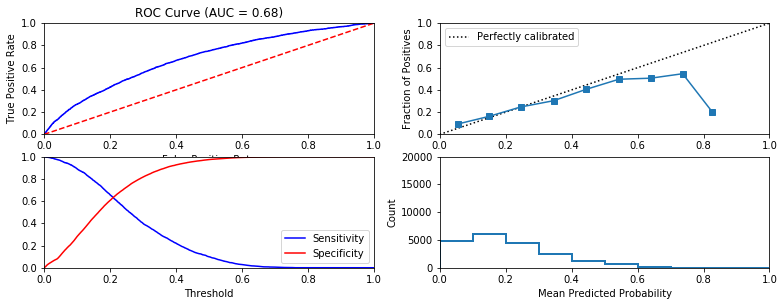


Similarity to LC grade ranking:  0.4774844807003006
Brier score: 0.15593596551963845
Were parameters on edge? : True
Score variations around CV search grid : 81.70469922108865
[0.02053532 0.01434213 0.04204804 0.03634481 0.05850862 0.04807829
 0.07366538 0.06013878 0.07839243 0.06649509]


In [16]:
## Train and test a random forest classifier

from sklearn.ensemble import RandomForestClassifier

cv_parameters = {
    "n_estimators": [25, 50]
    , "max_depth": [11,15,17,21,23]
}
random_forest = RandomForestClassifier(random_state = default_seed, n_jobs = -1)
random_forest = fit_classification(random_forest,data_dict, your_features, cv_parameters = cv_parameters, model_name = "RF", metric = "recall", number_iterations = 100)

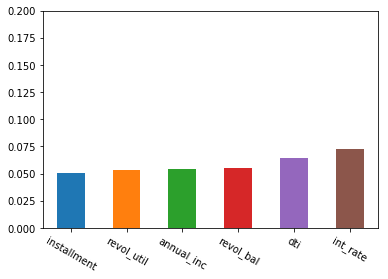

In [17]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Perceptron
Fit time: 214.63 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 25, 10)}

AUC-average and standard deviation: 0.6873988364419374,0.007082239643094317
Accuracy-average and standard deviation: 0.7855604999999999,0.004198918283320117
Precision-average and standard deviation: 0.2173904031979545,0.0034611636249351706
Recall-average and standard deviation: 0.9891733640477557,0.0029087027949204402
F1-average and standard deviation: 0.3564303804759528,0.004630470284616414
Thresholds-average and standard deviation: 0.4893615252640266,0.03132932385982459


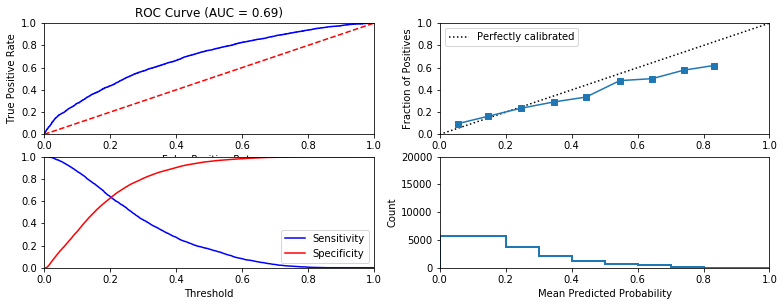


Similarity to LC grade ranking:  0.5584809633504164
Brier score: 0.15330504164498954
Were parameters on edge? : True
Score variations around CV search grid : 28.79003300458273
[0.09957485 0.08377208 0.07496865 0.10527832]


In [18]:
mlp = MLPClassifier()
cv_parameters = {"hidden_layer_sizes": [(25,10,5),(25,7),(50,25),(50,25,10)], "activation" : ["logistic"]}

mlp = fit_classification(mlp,data_dict,  your_features, cv_parameters=cv_parameters , model_name="Perceptron", metric = "recall", number_iterations=100)

In [19]:
# assess the extent to which YourModel's scores agree with the grades assigned by LendingClub
predicted_data = l1_logistic_class["model"].predict_proba(data_dict['X_test'])[:,1]
comparison_df = pd.DataFrame()
comparison_df["Grade"] = data[data_dict["test_set"]].grade
comparison_df["risk"] = predicted_data
comparison_df.groupby("Grade").mean()

,risk
Grade,
A,0.071643
B,0.150960
C,0.249069
D,0.355131
E,0.415856
F,0.493153
G,0.517615


## Train and Test logistic regression model with features derived by LendingClub

  Model: LRLC
Fit time: 1.48 seconds
Optimal parameters:
{'C': 0.1, 'penalty': 'l1'}

AUC-average and standard deviation: 0.6779946278785397,0.003603283135238838
Accuracy-average and standard deviation: 0.7911159999999999,0.0027494806782372583
Precision-average and standard deviation: 0.22817249425557112,0.015533767505698884
Recall-average and standard deviation: 0.962332719913362,0.03794058074947897
F1-average and standard deviation: 0.36820420110425345,0.016887161472493015
Thresholds-average and standard deviation: 0.6553779199348537,0.24251601357048028


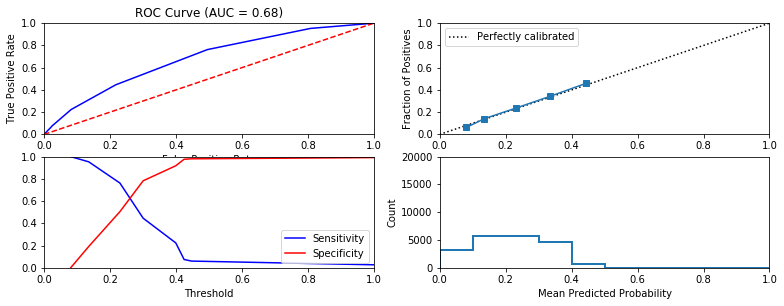


Similarity to LC grade ranking:  0.998925974532338
Brier score: 0.15591187463234832
Were parameters on edge? : True
Score variations around CV search grid : 0.025142474019440746
[0.79546667 0.79526667 0.79526667 0.79546667 0.79546667 0.79546667
 0.79546667]


In [20]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ["grade"]
a_lendingclub_feature2 = ["grade", "int_rate", "dti"] 
data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict,  a_lendingclub_feature, cv_parameters, model_name = "LRLC", number_iterations = 100)

  Model: L2 regularized logistic regression
Fit time: 0.95 seconds
Optimal parameters:
{'C': 0.1, 'penalty': 'l2'}

AUC-average and standard deviation: 0.6780219637988804,0.004636193925124443
Accuracy-average and standard deviation: 0.7911885000000001,0.0027421420003347747
Precision-average and standard deviation: 0.21871737418725007,0.01559223682555981
Recall-average and standard deviation: 0.9795220267348622,0.03996892340742074
F1-average and standard deviation: 0.35688495007074594,0.01681580551298363
Thresholds-average and standard deviation: 0.8175773475608935,0.26005799154834364


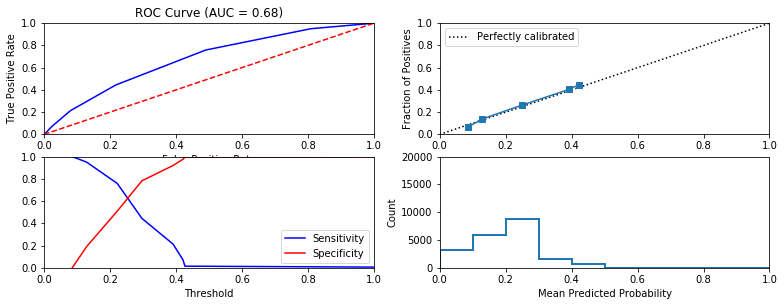


Similarity to LC grade ranking:  1.0
Brier score: 0.15559389192808565
Were parameters on edge? : True
Score variations around CV search grid : 0.025142474019440746
[0.79546667 0.79546667 0.79546667 0.79526667 0.79526667 0.79526667
 0.79546667 0.79546667 0.79546667 0.79546667 0.79546667]


In [21]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l2'], 'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1,2,3, 3.5, 4, 5]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict,a_lendingclub_feature, cv_parameters, 'L2 regularized logistic regression', number_iterations = 100)

## Train and test all the models you have tried previously after removing features derived by LendingClub 

  Model: LRLC
Fit time: 38.28 seconds
Optimal parameters:
{'C': 0.1, 'penalty': 'l1'}

AUC-average and standard deviation: 0.7019867098922412,0.004158333407420936
Accuracy-average and standard deviation: 0.7925460000000002,0.0030889778244590823
Precision-average and standard deviation: 0.21298919434731053,0.003234935297721248
Recall-average and standard deviation: 0.9956368587814776,0.0020939692412151167
F1-average and standard deviation: 0.3508976683167888,0.004348955863607265
Thresholds-average and standard deviation: 0.47493475458446455,0.018657909099418116


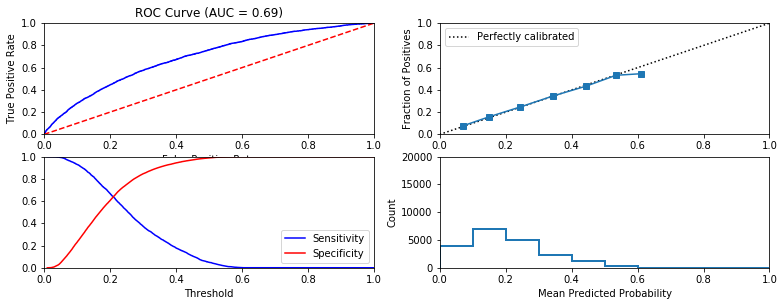


Similarity to LC grade ranking:  0.6640591982877821
Brier score: 0.15332818611231064
Were parameters on edge? : True
Score variations around CV search grid : 0.11299435028248737
[0.7965     0.79586667 0.7956     0.79593333 0.79596667 0.79596667
 0.796     ]


In [22]:
your_features_nlc = list(set(your_features) - set(a_lendingclub_feature2))

data_dict = prepare_data(feature_subset = your_features_nlc)
lc1_only_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, your_features_nlc, cv_parameters, model_name = "LRLC", number_iterations = 100)

  Model: Perceptron
Fit time: 188.51 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 25, 10)}

AUC-average and standard deviation: 0.6867860189964411,0.004943967752811344
Accuracy-average and standard deviation: 0.7860015,0.003422918747209754
Precision-average and standard deviation: 0.21691631744163936,0.003181708625880886
Recall-average and standard deviation: 0.9901537693837823,0.0026701212175781995
F1-average and standard deviation: 0.3558575372099688,0.0042155316447974305
Thresholds-average and standard deviation: 0.48540451942530555,0.030891209530108116


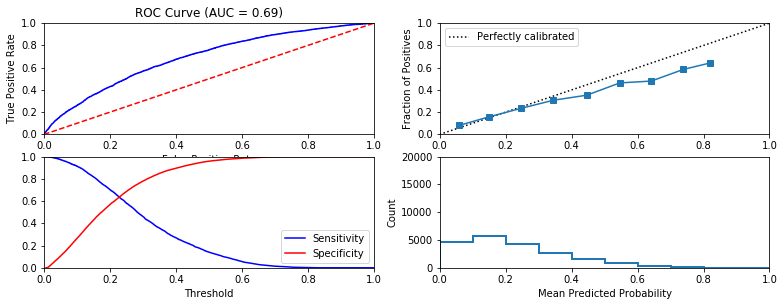


Similarity to LC grade ranking:  0.5709017372114906
Brier score: 0.15581870748465315
Were parameters on edge? : True
Score variations around CV search grid : 56.74234888340753
[0.1021848  0.0475875  0.06111611 0.11000945]


In [23]:
mlp = MLPClassifier(random_state = default_seed)
cv_parameters = {"hidden_layer_sizes": [(25,10,5),(25,7),(50,25),(50,25,10)], "activation" : ["logistic"]}

mlp = fit_classification(mlp, data_dict, your_features_nlc, cv_parameters=cv_parameters,  model_name="Perceptron", metric = "recall", number_iterations=100)



  Model: RF
Fit time: 30.67 seconds
Optimal parameters:
{'max_depth': 23, 'n_estimators': 25}

AUC-average and standard deviation: 0.6721629706412574,0.005001753590885771
Accuracy-average and standard deviation: 0.7503199999999999,0.004646434116610286
Precision-average and standard deviation: 0.21277793542504797,0.0027017231084517546
Recall-average and standard deviation: 0.9947752279122557,0.0012966972204918696
F1-average and standard deviation: 0.350562073763034,0.0036652982693219436
Thresholds-average and standard deviation: 0.31891737761276484,0.007179882522870062


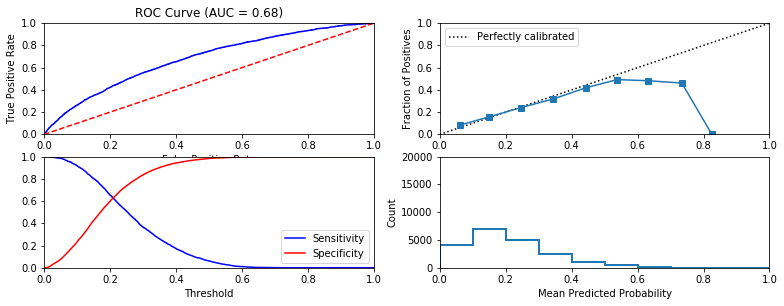


Similarity to LC grade ranking:  0.43013010382310507
Brier score: 0.1532884801359465
Were parameters on edge? : True
Score variations around CV search grid : 96.42888566192742
[0.00488886 0.00179258 0.01972006 0.01450478 0.02852037 0.01971944
 0.04612159 0.03292047 0.05019655 0.03927789]


In [24]:
from sklearn.ensemble import RandomForestClassifier

cv_parameters = {
    "n_estimators": [25, 50]
    , "max_depth": [11,15,17,21,23]
}
random_forest = RandomForestClassifier(random_state = default_seed, n_jobs = -1)
random_forest = fit_classification(random_forest,data_dict, your_features_nlc, cv_parameters = cv_parameters, model_name = "RF", metric = "recall", number_iterations=100)

  Model: decision_tree
Fit time: 2.45 seconds
Optimal parameters:
{'max_depth': 5}

AUC-average and standard deviation: 0.6578914245114338,0.004022824250685672
Accuracy-average and standard deviation: 0.790297,0.003118732274498727
Precision-average and standard deviation: 0.25853031277522115,0.023947962386348814
Recall-average and standard deviation: 0.7985792069605925,0.11800247924641245
F1-average and standard deviation: 0.3860999100387116,0.011936098584867057
Thresholds-average and standard deviation: 0.5452711469075154,0.04489947279463781


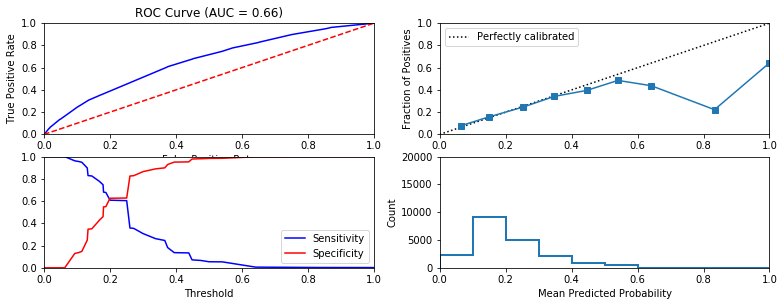


Similarity to LC grade ranking:  0.4644519036545113
Brier score: 0.15616405207424253
Were parameters on edge? : True
Score variations around CV search grid : 100.0
[0.         0.         0.         0.02346957 0.07774051]


In [25]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {"max_depth":range(1,6)}

decision_tree = fit_classification(decision_tree,data_dict, your_features_nlc, cv_parameters=cv_parameters,model_name="decision_tree", metric="recall",  number_iterations=100)

  Model: L2 regularized logistic regression
Fit time: 7206.3 seconds
Optimal parameters:
{'C': 0.1, 'penalty': 'l2'}

AUC-average and standard deviation: 0.7037974602262573,0.004076186823459423
Accuracy-average and standard deviation: 0.793203,0.0028477343626117945
Precision-average and standard deviation: 0.21276207528386754,0.0031564058209669127
Recall-average and standard deviation: 0.9954786899855127,0.0019043757828137906
F1-average and standard deviation: 0.35058051133195656,0.00426034406652477
Thresholds-average and standard deviation: 0.48287615743716544,0.017844186822558724


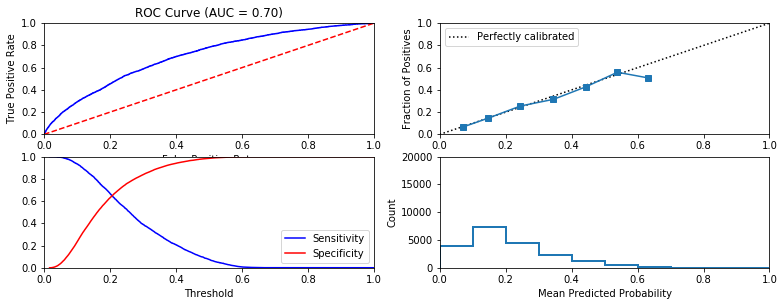


Similarity to LC grade ranking:  0.6816924151143348
Brier score: 0.14792965081052073
Were parameters on edge? : True
Score variations around CV search grid : 0.046042442760867226
[0.79636667 0.79603333 0.79636667 0.7962     0.79616667 0.79613333
 0.79603333 0.79603333 0.79603333 0.796      0.7961    ]


In [26]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(random_state=0)
cv_parameters = {'penalty': ['l2'], 'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1,2,3, 3.5, 4, 5]}

l2_logistic = fit_classification(l2_logistic, data_dict, your_features_nlc,cv_parameters, 'L2 regularized logistic regression', number_iterations=100)

  Model: NB
Fit time: 1.19 seconds
Optimal parameters:
{'var_smoothing': 3e-10}

AUC-average and standard deviation: 0.6731727440685219,0.004056252325244871
Accuracy-average and standard deviation: 0.7913024999999999,0.0026812905008596166
Precision-average and standard deviation: 0.20876007180643896,0.002692250400567088
Recall-average and standard deviation: 1.0,0.0
F1-average and standard deviation: 0.34540371839092915,0.003684725400960587
Thresholds-average and standard deviation: 1.0,0.0


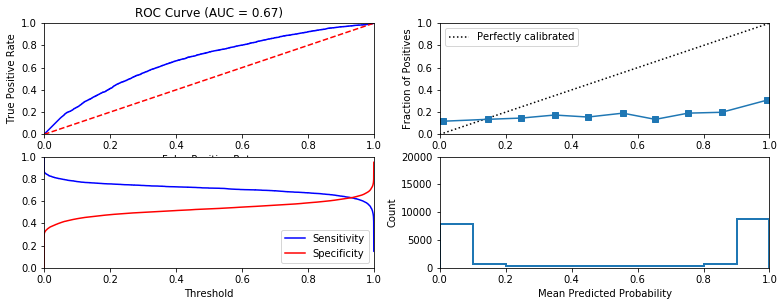


Similarity to LC grade ranking:  0.6827931882066277
Brier score: 0.3951062786779603
Were parameters on edge? : True
Score variations around CV search grid : 1.3828811115480408
[0.50156667 0.50576667 0.5086    ]


In [27]:
## Train and test a naive bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = fit_classification(gnb,data_dict,your_features_nlc, cv_parameters = {"var_smoothing":[0.0000000001, 0.0000000002,0.0000000003]}, model_name = "NB", number_iterations=100)

## Time stability test of YOURMODEL

  Model: L1 regularized logistic regression
Fit time: 0.42 seconds
Optimal parameters:
{'C': 0.1, 'penalty': 'l1'}

AUC-average and standard deviation: 0.7025724408613453,0.0045243739066568546
Accuracy-average and standard deviation: 0.79331,0.0014982990355733173
Precision-average and standard deviation: 0.21286843334711142,0.00175823168377562
Recall-average and standard deviation: 0.9950477177540955,0.00145607046862433
F1-average and standard deviation: 0.3507062523170589,0.002362222515711117
Thresholds-average and standard deviation: 0.46902830188607014,0.015507933385362476


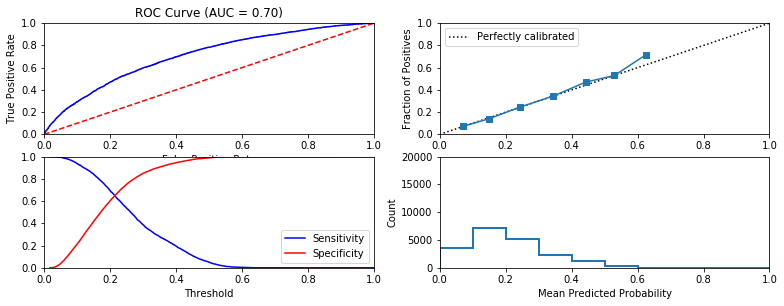


Similarity to LC grade ranking:  0.6627344490612479
Brier score: 0.1503224901405882
Were parameters on edge? : True
Score variations around CV search grid : 0.3783783783783751
[0.87264151 0.87264151 0.87264151 0.87169811 0.87075472 0.86933962
 0.86933962]


In [28]:
## Define the time window of your train and test data

from datetime import datetime
start_date_train = datetime.strptime("2009-01-01", "%Y-%m-%d").date()
end_date_train = datetime.strptime("2009-12-31", "%Y-%m-%d").date()
start_date_test = datetime.strptime("2017-01-02", "%Y-%m-%d").date()
end_date_test = datetime.strptime("2017-12-31", "%Y-%m-%d").date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features_nlc)

## Train and test YOURMODEL using this data

l1_logistic = LogisticRegression(random_state=default_seed)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
l1_logistic_class = fit_classification(l1_logistic, data_dict_test, your_features_nlc, cv_parameters, 'L1 regularized logistic regression', number_iterations = 10)




  Model: L1 regularized logistic regression
Fit time: 5.78 seconds
Optimal parameters:
{'C': 1, 'penalty': 'l1'}

AUC-average and standard deviation: 0.7062694885487323,0.005268627424472419
Accuracy-average and standard deviation: 0.79238,0.002540787279565134
Precision-average and standard deviation: 0.21415247329662881,0.0018533750838549052
Recall-average and standard deviation: 0.995661967910077,0.0015570049415906512
F1-average and standard deviation: 0.35248592213753893,0.0025372254909516974
Thresholds-average and standard deviation: 0.48867773091696814,0.020716582838562196


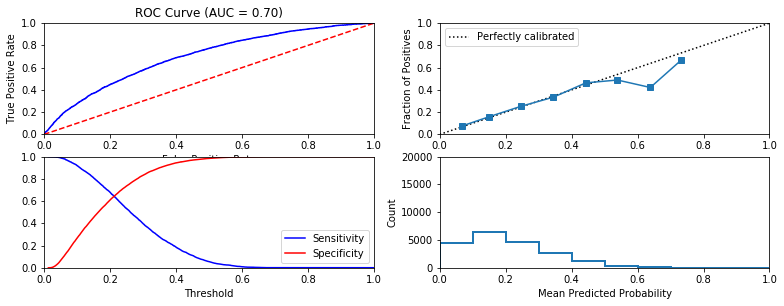


Similarity to LC grade ranking:  0.7101982723674134
Brier score: 0.1527329957475211
Were parameters on edge? : True
Score variations around CV search grid : 0.580270793036746
[0.74244444 0.74522222 0.746      0.74677778 0.74644444 0.74511111
 0.744     ]


In [29]:
## Define the time window of your train and test data

from datetime import datetime
start_date_train = datetime.strptime("2016-01-01", "%Y-%m-%d").date()
end_date_train = datetime.strptime("2016-12-31", "%Y-%m-%d").date()
start_date_test = datetime.strptime("2017-01-02", "%Y-%m-%d").date()
end_date_test = datetime.strptime("2017-12-31", "%Y-%m-%d").date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features_nlc)

## Train and test YOURMODEL using this data

l1_logistic = LogisticRegression(random_state=default_seed)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
l1_logistic_class = fit_classification(l1_logistic, data_dict_test, your_features_nlc, cv_parameters, 'L1 regularized logistic regression', number_iterations = 10)




## Train and test YOURMODEL on the original data

In [30]:
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

continuous_features = list(set(continuous_features))# - set(["last_pymnt_amnt","last_fico_range_high", "last_fico_range_low"]))
discrete_features = list(set(discrete_features) - set(["title","zip_code","emp_length","emp_title"]))

data["outcome"] = list(map( status,data["loan_status"]))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
data['train'] = list(map(training_test, [p]*len(data['cr_hist'])))


# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

  Model: L1 regularized logistic regression
Fit time: 13.73 seconds
Optimal parameters:
{'C': 1, 'penalty': 'l1'}

AUC-average and standard deviation: 0.9834905674126369,0.0006345136353446107
Accuracy-average and standard deviation: 0.9463999999999999,0.0015735310610216961
Precision-average and standard deviation: 0.2642058526984549,0.05097500920643881
Recall-average and standard deviation: 0.999567081049072,0.00014541447198538615
F1-average and standard deviation: 0.41555916465985776,0.05900925658307214
Thresholds-average and standard deviation: 0.4707034392635213,0.03485299784306759


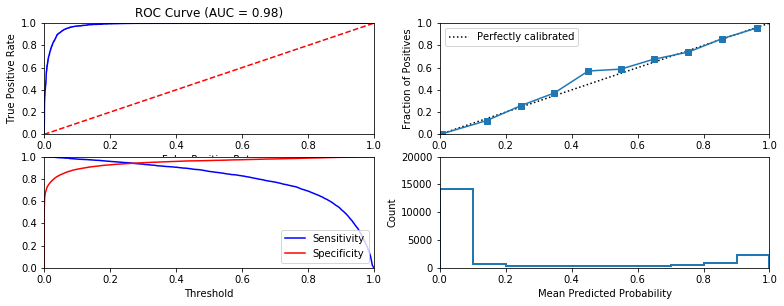


Similarity to LC grade ranking:  0.10836719324120715
Brier score: 0.04026593238680026
Were parameters on edge? : True
Score variations around CV search grid : 0.6717044500419834
[0.92011111 0.92588889 0.92522222 0.92633333 0.92522222 0.925
 0.92477778]


In [31]:

from datetime import datetime
start_date_train = datetime.strptime("2010-02-01", "%Y-%m-%d").date()
end_date_train = datetime.strptime("2015-02-01", "%Y-%m-%d").date()
start_date_test = datetime.strptime("2015-02-02", "%Y-%m-%d").date()
end_date_test = datetime.strptime("2017-12-01", "%Y-%m-%d").date()
your_features = list(continuous_features + discrete_features)


data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

l1_logistic_full = LogisticRegression(random_state=default_seed)
cv_parameters = {'penalty': ['l1'], 'C': [0.1, 0.2, 0.3, 1, 1.5, 2, 3]}
l1_full_data = fit_classification(l1_logistic_full, data_dict_test, your_features, cv_parameters, 'L1 regularized logistic regression', number_iterations = 10)


In [9]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )


continuous_features = list(set(continuous_features) - set(["last_pymnt_amnt","last_fico_range_high", "last_fico_range_low"]))
discrete_features = list(set(discrete_features) - set(["title","zip_code","emp_length","emp_title"]))

## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
def status(x):
    return(x  in ["Charged Off", "Default"] )
data["outcome"] = list(map( status,data["loan_status"]))

# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
def training_test(p):
    a = np.random.binomial(1,p)
    if a == 1:
        return True
    return False
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p = 0.5
data['train'] = list(map(training_test, [p]*len(data['cr_hist'])))
data["outcome"] = list(map( status,data["loan_status"]))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## define your set of features to use in different models
your_features = continuous_features + discrete_features

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)


## Test regression models

In [33]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 
        
        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [34]:
## First, trying l1 regularized linear regression with hyper-parameters

from sklearn import linear_model

l1_regression = linear_model.Lasso()
cv_parameters = {'alpha': np.linspace(0.01,0.1,11)}

l1_logistic = fit_regression(l1_regression, data_dict, cv_parameters, model_name = 'L1 regularized logistic regression')

  Model: L1 regularized logistic regression  Return column: ret_PESS
Fit time: 2.56 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -1.2971277036699647e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831
 -0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831]
  Model: L1 regularized logistic regression  Return column: ret_OPT
Fit time: 2.49 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -2.011199670715058e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187
 -0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187]
  Model: L1 regularized logistic regression  Return column: ret_INTa
Fit time: 2.49 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -3.19686299021793e-05

### $l_2$ regularized linear regressor

In [35]:
## trying l2 regularized linear regression with hyper-parameters

## First, trying l1 regularized linear regression with hyper-parameters
from sklearn import linear_model

l2_regression = linear_model.Ridge(random_state=0)
cv_parameters = {'alpha': np.linspace(0.01,0.1,11)}
reg_ridge = fit_regression(l1_regression, data_dict, cv_parameters, model_name = 'L2 regularized logistic regression')

  Model: L2 regularized logistic regression  Return column: ret_PESS
Fit time: 2.69 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -1.2971277036699647e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831
 -0.08873831 -0.08873831 -0.08873831 -0.08873831 -0.08873831]
  Model: L2 regularized logistic regression  Return column: ret_OPT
Fit time: 2.55 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -2.011199670715058e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187
 -0.00695187 -0.00695187 -0.00695187 -0.00695187 -0.00695187]
  Model: L2 regularized logistic regression  Return column: ret_INTa
Fit time: 2.5 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -3.19686299021793e-05


### Multi-layer perceptron regressor

In [36]:
## trying multi-layer perceptron regression with hyper-parameters


mlp = MLPRegressor(random_state = default_seed)
cv_parameters = {"hidden_layer_sizes": [(25,10,5),(25,7),(50,25),(50,25,10)], "activation" : ["logistic"]}

mlp_reg = fit_regression(mlp, data_dict, cv_parameters, model_name = 'MLP regression')

  Model: MLP regression  Return column: ret_PESS
Fit time: 18.47 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 25)}

Testing r2 score: 0.0203040565992596
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -34.42007787322726
All test scores : [-0.08455698 -0.09366405 -0.07032917 -0.09453652]
  Model: MLP regression  Return column: ret_OPT
Fit time: 17.65 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 25, 10)}

Testing r2 score: 0.016969837575037672
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 154.2967679480523
All test scores : [ 0.00234883 -0.00510739  0.00094402  0.00940644]
  Model: MLP regression  Return column: ret_INTa
Fit time: 18.79 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 25)}

Testing r2 score: 0.014049344269919772
Were parameters on edge (model) : True
Score variations around CV search g

### Random forest regressor

In [37]:
## trying random forest regression with hyper-parameters

from sklearn.ensemble import RandomForestClassifier

cv_parameters = {
    "n_estimators": [25, 50]
    , "max_depth": [11,15,17,21,23]
}
random_forest = RandomForestRegressor(random_state = default_seed, n_jobs = -1)
reg_rf = fit_regression(random_forest,data_dict, cv_parameters = cv_parameters, model_name = "RF Regressor")

  Model: RF Regressor  Return column: ret_PESS
Fit time: 185.59 seconds
Optimal parameters:
{'max_depth': 11, 'n_estimators': 50}

Testing r2 score: 0.02865431201685331
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -51.196109453785276
All test scores : [-0.07954536 -0.07362869 -0.08784559 -0.07772124 -0.09344823 -0.08133114
 -0.10574844 -0.09018802 -0.11132372 -0.09208395]
  Model: RF Regressor  Return column: ret_OPT
Fit time: 182.59 seconds
Optimal parameters:
{'max_depth': 11, 'n_estimators': 50}

Testing r2 score: 0.018327362534926284
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 519.2471712694153
All test scores : [ 0.00426163  0.006997   -0.00631896  0.00080819 -0.01527384 -0.00588637
 -0.02490275 -0.01346462 -0.02933473 -0.016737  ]
  Model: RF Regressor  Return column: ret_INTa
Fit time: 185.0 seconds
Optimal parameters:
{'max_depth': 11, 'n_estimators': 50}

Testing r2 score: 0.0321366405512916

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [38]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = np.average(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = np.average(pf_test[colname]) 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test =  np.average(pf_test[ret_col]) 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = ret_test =  np.average(pf_test[ret_col]) 

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [39]:

mlp = MLPRegressor(random_state = default_seed)
cv_parameters = {"hidden_layer_sizes": [(25,10,5),(25,7),(50,25),(50,25,10)], "activation" : ["logistic"]}

mlp_reg = fit_regression(mlp, data_dict, cv_parameters, separate = True,model_name = 'MLP regression')

  Model: MLP regression  Return column: ret_PESS
Fit time: 18.74 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'hidden_layer_sizes': (50, 25, 10)} model_1 {'activation': 'logistic', 'hidden_layer_sizes': (25, 7)}

Testing r2 scores:
model_0: 0.25863944989287724
model_1: 0.0830071972111246
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 609.7549925526677
All test scores : [-0.08739473 -0.03019849 -0.04150782  0.01714446]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -48.53883336548226
All test scores : [-0.27526957 -0.18531826 -0.24197715 -0.25106737]
  Model: MLP regression  Return column: ret_OPT
Fit time: 20.3 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'hidden_layer_sizes': (25, 7)} model_1 {'activation': 'logistic', 'hidden_layer_sizes': (25, 7)}

Testing r2 scores:
model_0: 0.7061803448322219
model_1: 0.08075108179292811
Were parameters on edge (model_0) 

In [40]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {
    "n_estimators": [25, 50]
    , "max_depth": [11,15,17,21,23]
}
random_forest = RandomForestRegressor(random_state = default_seed, n_jobs = -1)
reg_separate = fit_regression(random_forest,data_dict,separate = True,  cv_parameters = cv_parameters, model_name = "RF Regressor")

  Model: RF Regressor  Return column: ret_PESS
Fit time: 161.17 seconds
Optimal parameters:
model_0: {'max_depth': 11, 'n_estimators': 50} model_1 {'max_depth': 11, 'n_estimators': 50}

Testing r2 scores:
model_0: 0.3904456015184873
model_1: 0.10877245289925719
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -173.77588051388605
All test scores : [-0.01102572 -0.01030281 -0.02649474 -0.02263803 -0.0282066  -0.02491622
 -0.02558505 -0.02220158 -0.02803857 -0.02281693]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -18.970805585194455
All test scores : [-0.18004633 -0.17597747 -0.18723193 -0.18129953 -0.19635649 -0.18725345
 -0.2073325  -0.19799106 -0.20936181 -0.19703065]
  Model: RF Regressor  Return column: ret_OPT
Fit time: 158.79 seconds
Optimal parameters:
model_0: {'max_depth': 11, 'n_estimators': 50} model_1 {'max_depth': 11, 'n_estimators': 50}

Testing r2 scores:
model_0: 0.736479745398091
m

In [41]:
## First, trying l1 regularized linear regression with hyper-parameters

from sklearn import linear_model

l1_regression = linear_model.Lasso()
cv_parameters = {'alpha': np.linspace(0.01,0.1,11)}

l1_logistic = fit_regression(l1_regression, data_dict, cv_parameters, separate = True, model_name = 'L1 regularized logistic regression')

  Model: L1 regularized logistic regression  Return column: ret_PESS
Fit time: 2.95 seconds
Optimal parameters:
model_0: {'alpha': 0.01} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: -5.5829662992668005e-05
model_1: 0.03697390295775849
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -0.0
All test scores : [-0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586
 -0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -15.732814115090148
All test scores : [-0.26092167 -0.30197199 -0.30197199 -0.30197199 -0.30197199 -0.30197199
 -0.30197199 -0.30197199 -0.30197199 -0.30197199 -0.30197199]
  Model: L1 regularized logistic regression  Return column: ret_OPT
Fit time: 2.55 seconds
Optimal parameters:
model_0: {'alpha': 0.01} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: -2.3936359633935922e-05
model_1: 0.03586409365403309


In [42]:
## trying l2 regularized linear regression with hyper-parameters

## First, trying l1 regularized linear regression with hyper-parameters
from sklearn import linear_model

l2_regression = linear_model.Ridge(random_state=0)
cv_parameters = {'alpha': np.linspace(0.01,0.1,11)}
reg_ridge = fit_regression(l1_regression, data_dict, cv_parameters, separate = True, model_name = 'L2 regularized logistic regression')

  Model: L2 regularized logistic regression  Return column: ret_PESS
Fit time: 1.48 seconds
Optimal parameters:
model_0: {'alpha': 0.01} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: -5.5829662992668005e-05
model_1: 0.03697390295775849
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -0.0
All test scores : [-0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586
 -0.34193586 -0.34193586 -0.34193586 -0.34193586 -0.34193586]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -15.732814115090148
All test scores : [-0.26092167 -0.30197199 -0.30197199 -0.30197199 -0.30197199 -0.30197199
 -0.30197199 -0.30197199 -0.30197199 -0.30197199 -0.30197199]
  Model: L2 regularized logistic regression  Return column: ret_OPT
Fit time: 1.45 seconds
Optimal parameters:
model_0: {'alpha': 0.01} model_1 {'alpha': 0.01}

Testing r2 scores:
model_0: -2.3936359633935922e-05
model_1: 0.03586409365403309


In [43]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'
classifier = l1_logistic_class
regressor = reg_rf
print('strategy:',test_strategy)  
num_iter = 100
return_ditc = {'ret_PESS':0, 'ret_OPT':0,'ret_INTa':0, 'ret_INTb':0}
for i in range(num_iter):    
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    strat_rand = test_investments(data_dict,  classifier = classifier, regressor = regressor, strategy = test_strategy)
    for ret_col in col_list:
        return_ditc[ret_col] = return_ditc[ret_col] + strat_rand[ret_col]['average return']
for ret_col in col_list:
    print(ret_col + ': ' + str(return_ditc[ret_col]/num_iter))

strategy: Random
ret_PESS: 0.009204646455282626
ret_OPT: 0.049766173681568375
ret_INTa: 0.02487906885091619
ret_INTb: 0.06056139836376104


In [44]:
test_strategy = 'Default-based'
classifier = l1_logistic_class
regressor = reg_rf
print('strategy:',test_strategy)  
num_iter = 100
return_ditc = {'ret_PESS':0, 'ret_OPT':0,'ret_INTa':0, 'ret_INTb':0}
for i in range(num_iter):    
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    strat_rand = test_investments(data_dict,  classifier = classifier, regressor = regressor, strategy = test_strategy)
    for ret_col in col_list:
        return_ditc[ret_col] = return_ditc[ret_col] + strat_rand[ret_col]['average return']
for ret_col in col_list:
    print(ret_col + ': ' + str(return_ditc[ret_col]/num_iter))

strategy: Default-based
ret_PESS: 0.007612059706912543
ret_OPT: 0.049203900943957955
ret_INTa: 0.025294011001257114
ret_INTb: 0.06167184028824842


In [45]:
test_strategy = 'Return-based'

classifier = l1_logistic_class
regressor = reg_rf
print('strategy:',test_strategy)  
num_iter = 100
return_ditc = {'ret_PESS':0, 'ret_OPT':0,'ret_INTa':0, 'ret_INTb':0}
for i in range(num_iter):    
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    strat_rand = test_investments(data_dict,  classifier = classifier, regressor = regressor, strategy = test_strategy)
    for ret_col in col_list:
        return_ditc[ret_col] = return_ditc[ret_col] + strat_rand[ret_col]['average return']
for ret_col in col_list:
    print(ret_col + ': ' + str(return_ditc[ret_col]/num_iter))

strategy: Return-based
ret_PESS: 0.028982361995450887
ret_OPT: 0.09513592027041005
ret_INTa: 0.04066260704015246
ret_INTb: 0.07813689645059084


In [46]:
test_strategy = 'Default-return-based'

classifier = l1_logistic_class
regressor = reg_rf
print('strategy:',test_strategy)  
num_iter = 100
return_ditc = {'ret_PESS':0, 'ret_OPT':0,'ret_INTa':0, 'ret_INTb':0}
for i in range(num_iter):    
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    strat_rand = test_investments(data_dict,  classifier = classifier, regressor = reg_separate, strategy = test_strategy)
    for ret_col in col_list:
        return_ditc[ret_col] = return_ditc[ret_col] + strat_rand[ret_col]['average return']
for ret_col in col_list:
    print(ret_col + ': ' + str(return_ditc[ret_col]/num_iter))

strategy: Default-return-based
ret_PESS: 0.018619251594706045
ret_OPT: 0.04952243304881142
ret_INTa: 0.024552374136947927
ret_INTb: 0.06053259597562637


In [10]:
#Best strategy
ret_pess = data.ret_PESS
np.sort(ret_pess)[::-1]
print(np.mean(ret_pess[0:1000]))


ret_opt = data.ret_OPT
np.sort(ret_opt)[::-1]
print(np.mean(ret_opt[0:1000]))


ret_inta = data.ret_INTa
np.sort(ret_inta)[::-1]
print(np.mean(ret_inta[0:1000]))

ret_intb = data.ret_INTb
np.sort(ret_intb)[::-1]
print(np.mean(ret_intb[0:1000]))

0.029552499614656003
0.04876042038929439
0.04184867470338538
0.07576167620329928


## Sensitivity test of portfolio size

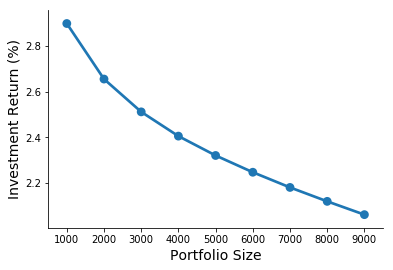

In [47]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict,  classifier =classifier , regressor =regressor , strategy = 'Return-based', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()